
# Laboratorio # 1: Convolutional Neural Networks
## ** Integrantes:**  Veronica Chimbo,  Kevin Calle, Javier Parra
## **Fecha:**  12 de noviembre de 2018

                            

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Paso 1. Carga de datos

In [1]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob
import random
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import optimizers
from sklearn.metrics import classification_report
from keras import optimizers




# Se importa esta librería para no mostrar las advertencias
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
# Bajamos los datos de entrenamiento

keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo

!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

#  Bajamos los datos de test

keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")

# Descomprimimos el archivo

!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.

MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64

IMG_SIZE = 64

In [0]:
# Función para igualar el tamaño de las imágenes de train

def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [0]:
# Función para igualar el tamaño de las imágenes de test

def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [6]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.

DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

x, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
x_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [0]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.

perm = np.random.permutation(len(x))
x, y = x[perm], y[perm]

### Funciones para realizar gráficos de métricas de evaluación

In [0]:
# Funciones para realizar gráficos de accuaracy y loss

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

In [0]:
# Función para visualizar un ejemplo del dataset

def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

## Paso 2 Descripción y Exploración de los datos

![texto alternativo](https://upload.wikimedia.org/wikipedia/en/c/ca/Simpsons_cast.png)

Para el desarrollo del presente laboratorio se utilizaron los datos de caracteres Simpson disponibles en:

* [Primero, bajamos los datos de entrenamiento](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60)

* [Segundo, bajamos los datos de test](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8)


Este conjunto de datos se compone de 18 carpetas para el proceso de entrenamiento (una para cada personaje) con 400-2000 imágenes en cada carpeta. Incluye también una carpeta con 990 imágenes etiquetadas.

Por lo tanto, se define dos funciones load_train_set y load_test_set que cargan, redimensionan y preparan las imágenes desde el conjunto de train y el conjunto de test, respectivamente.

Cada imagen se redimensiona en un formato de 64x64 píxeles con el algoritmo para remuestreo.

## Paso 3 Normalización de los datos



Una vez cargados los datos. Realizamos una normalización en escala de grises para reducir el efecto de las diferencias de iluminación.

Además, la CNN converge más rápido en los datos [0..1] que en los datos [0..255].

Simplemente dividimos los valores RGB por 255, que es el valor máximo de RGB.

In [0]:
# Normalizar los datos 

X_train  =  x/255.0 
X_test  =  x_t/255.0
Y_train = y
Y_test  =  y_t

### 3.1 Dimensiones de los conjuntos train y test

Vemos que en el dataset hay 18992 imágenes de training y 890 imágenes de test. Es decir, el modelo se entrenará con 18992 muestras y se evaluará con 890 muestras.

Luego, si tomamos una de los elementos vemos que tiene una dimensión de 64 x 64 píxeles. Por lo tanto podemos concluir que todas las imágenes en el dataset tienen esa dimensión.

In [11]:
# Imprimimos en pantalla las dimensiones de los arrays "x_train" y "x_test"

X_train_shape = x.shape
X_test_shape = x_t.shape
Y_train_shape = y.shape
Y_test_shape = y_t.shape

print("Dimensión de x_train: " + str(X_train_shape))
print("Dimensión de x_test: " + str(X_test_shape)+ "\n")
print("Dimensión de y_train: " + str(Y_train_shape))
print("Dimensión de y_test: " + str(Y_test_shape)+ "\n")

# Imprimimos en pantalla las dimensiones de un elemento dentro los dos arrays

print("Tamaño de un elemento de x_train[0]: " + str(x[1].shape))
print("Tamaño de un elemento de x_test[0]: " + str(x_t[15].shape) + "\n")

# Imprimimos en pantalla el número y tamaño de las imágenes en los arrays "x_train", "x_test"

print("El array de training tiene: " + str(X_train_shape[0]) + " imágenes de tamaño: " + str(X_train_shape[1]) + "x" + str(X_train_shape[2]) + " píxeles")
print("El array de test tiene: " + str(X_test_shape[0]) + " imágenes de tamaño: " + str(X_test_shape[1]) + "x" + str(X_test_shape[2]) + " píxeles")

Dimensión de x_train: (18992, 64, 64, 3)
Dimensión de x_test: (890, 64, 64, 3)

Dimensión de y_train: (18992,)
Dimensión de y_test: (890,)

Tamaño de un elemento de x_train[0]: (64, 64, 3)
Tamaño de un elemento de x_test[0]: (64, 64, 3)

El array de training tiene: 18992 imágenes de tamaño: 64x64 píxeles
El array de test tiene: 890 imágenes de tamaño: 64x64 píxeles


A continuación, vamos a visualizar algunas muestras. Para esto definimos dos funciones, una que muestra al azar 20 imágenes con sus etiquetas observadas y sus predichas (si se proporcionan todos los argumentos). La otra función selecciona aleatoriamente un elemento por tipo en una matriz. Esta última función se utilizará para elegir el nombre del personaje a mostrar.

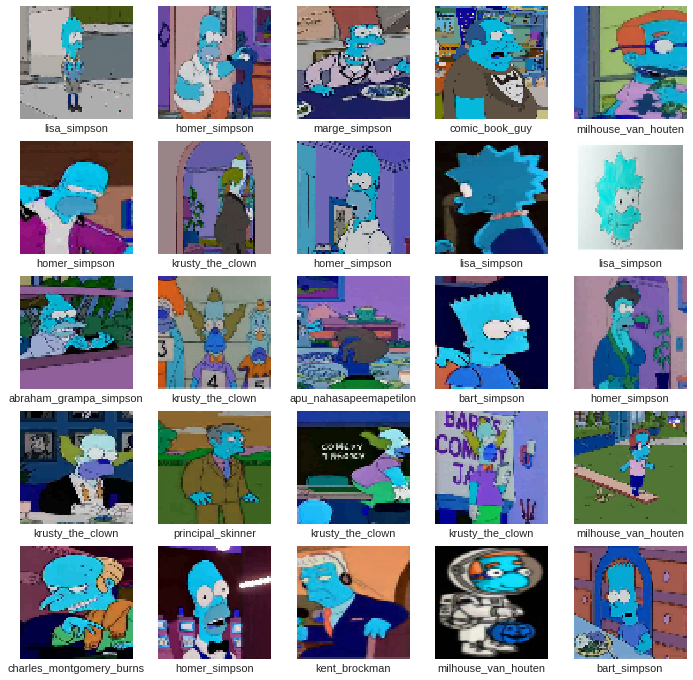

In [12]:
# Visualizamos algunas muestras de las clases del dataset

plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(MAP_CHARACTERS[Y_train[i]])

## Paso 4. Codificación de etiquetas

Se convierte a tipo categórico las etiquetas de los datos.

In [0]:
#Codificar etiquetas en vectores  (ej: 2 -> [0,0,1,0,0,0,0,0,0,0]) 

Y_train = to_categorical(Y_train, num_classes = 18)
Y_test = to_categorical(Y_test, num_classes = 18)

## Paso 5. Definición del modelo "Red neuronal tipo CNN"


Una red neuronal convolucional es una red multicapa que consta de capas  convolucionales  y de  submuestreo alternadas, y al final tiene capas de conexión total como una red perceptrón multicapa.

En la convolución se realizan operaciones de productos y sumas entre la capa de partida y los n filtros (o kernel) que genera un mapa de características. Los características extraídas corresponden a cada posible ubicación del filtro en la imagen original.

La ventaja es que el mismo filtro (= neurona) sirve para extraer la misma característica en cualquier parte de la entrada, con esto se consigue reducir el número de conexiones y el número de parámetros a entrenar en comparación con una red multicapa de conexión total.

Después de aplicar la convolución se le aplica a los mapas de características una función de activación.

La función de activación recomendada es signoide ReLU, seleccionando una tasa de aprendizaje adecuada y monitorizar la fracción de neuronas muertas, también se puede podría probar con Leaky ReLu o Maxout, pero nunca utilizar sigmoide logística. 

Reducción – pooling
En la reducción se disminuye la cantidad de parámetros al quedarse con las características más comunes.

La forma de reducir parámetros se realiza mediante la extracción de estadísticas como el promedio o el máximo de una región fija del mapa de características, al reducir características el método pierde precisión aunque mejora su compatibilidad.

![texto alternativo](http://www.diegocalvo.es/wp-content/uploads/2017/07/red-neuronal-convolucional-arquitectura.png)

###### fuente: http://www.diegocalvo.es/red-neuronal-convolucional-cnn/



In [0]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_clases = 18
epochs = 13

In [15]:
# Se crea la arquitectura de la red neuronal

# Con 12288 (64x64x3) inputs que provienen de cada píxel de las imágenes
# Con 2 capas convolucionales (3x3x32)
# Con capa max pooling (2x2)
# Con batch normalization
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos


# Con 2 capas convolucionales (3x3x64)
# Con capa max pooling (2x2)
# Con batch normalization
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos


# Con 2 capas convolucionales (3x3x86)
# Con capa max pooling (2x2)
# Con batch normalization
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos


# Con una capa flatten que aplana la entrada
# Con 1 capa densa de 512 neuronas y función de activación relu
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con 1 capa densa de salida de 18 neuronas una por cada clase
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad


model = Sequential()


model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(18, activation = "softmax"))
   
# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
__________

** 5.2. Configurar el optimizador ** 

In [0]:
# Se define el optimizer
adagrad = optimizers.adagrad()
#RMSprop = RMSprop(lr=0.001, decay=1e-6)
model.compile(optimizer = adagrad , loss = "categorical_crossentropy", metrics=["accuracy"])

** 5.3. Entrenamiento del modelo **

Vemos que vamos a entrenar el modelo con datos de train y probando la precisión con datos de validación. Los datos de validación repesentan el 20% de los datos de train.


In [17]:
# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Train on 15193 samples, validate on 3799 samples
Epoch 1/13
15193/15193 [==============================] - 18s 1ms/step - loss: 2.9720 - acc: 0.2626 - val_loss: 2.2023 - val_acc: 0.3382
Epoch 2/13
15193/15193 [==============================] - 16s 1ms/step - loss: 1.6193 - acc: 0.5088 - val_loss: 1.5345 - val_acc: 0.5317
Epoch 3/13
15193/15193 [==============================] - 16s 1ms/step - loss: 1.2147 - acc: 0.6331 - val_loss: 1.0581 - val_acc: 0.6786
Epoch 4/13
15193/15193 [==============================] - 16s 1ms/step - loss: 0.9792 - acc: 0.6986 - val_loss: 0.8653 - val_acc: 0.7389
Epoch 5/13
15193/15193 [==============================] - 16s 1ms/step - loss: 0.7895 - acc: 0.7564 - val_loss: 1.7270 - val_acc: 0.5517
Epoch 6/13
15193/15193 [==============================] - 16s 1ms/step - loss: 0.6558 - acc: 0.7917 - val_loss: 0.7149 - val_acc: 0.7907
Epoch 7/13
15193/15193 [==============================] - 16s 1ms/step - loss: 0.5730 - acc: 0.8193 - val_loss: 0.5950 - val_acc:

**Observaciones**

Podemos observar que nuestro modelo alcanza una precisión del 86% con datos de validación y un 50% de coste. En la curva de precisión vemos que caemos en overfitting a partir de la época 10.

El modelo se entrena perfectamente con 12 épocas antes de caer en sobre ajuste.

Vemos que en el tramo de 8-12 épocas el modelo llega a su máximo valor de precisión en datos de validación.

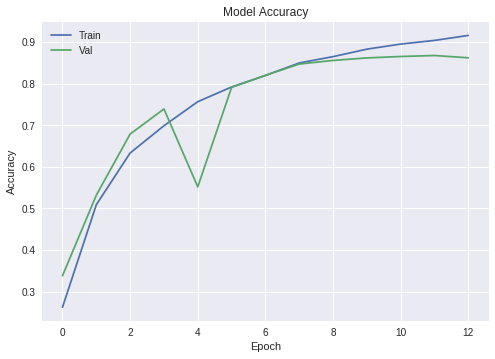

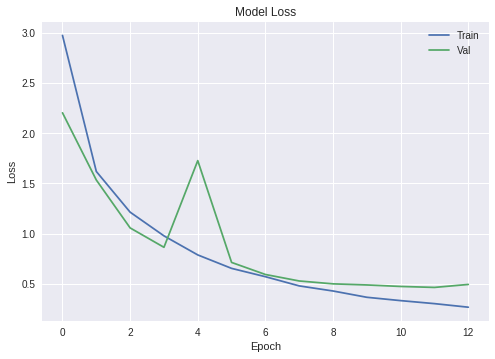

In [18]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history)

plot_loss(history)

## Paso 6  Evaluación del modelo en datos de test

**6.1 Precisión y pérdidas del modelo**

Utilizando el modelo recién entrenado, obtenemos  la accuracy resultante en el dataset de test. Aquí vemos que obtenemos una precisión de 95% con datos de test. 

In [19]:
# Se obtiene la precisión y pérdidas del modelo

loss, acc = model.evaluate(X_test, Y_test,batch_size=batch_size)
print('Pérdida en Test:', loss)
print('Accuracy en Test:', acc)

890/890 [==============================] - 0s 544us/step
Pérdida en Test: 0.15795671712146717
Accuracy en Test: 0.9595505617977528


** 6.2. Predicciones **

Utilizando el método predict de Keras, realizamos predicciones para los datos de test. Hacemos uso de la función predict para hacer predicciones sobre algunas imágenes

In [0]:
# Se obtienen las predicciones sobre el conjunto de test

predictions = model.predict(X_test)

Aquí, el modelo ha predicho la etiqueta para cada imagen en el conjunto de pruebas. Presentamos la primera predicción:

In [21]:
# Se obtiene la predicción para una muestra

predictions[0].round()

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

La predicción del primer elemento es un vector con probabilidades. En este caso se muestra como ceros y unos porque redondeamos los valores. 

La última capa utiliza una función softmax que normaliza las salidas entre 0 y 1 asignando probabilidades decimales a cada clase en un caso de clases múltiples. Estas probabilidades suman 1. Se utiliza en problemas de clases excluyentes o en donde solo una clase es posible.Es decir, la salida es una distrubución de probabilidad con los valores de probabilidad de cada clase.

In [22]:
# Se saca el índice de la máxima predicción

np.argmax(predictions[0])

1

Ahora mostramos los valores reales para el primer elemento en el conjunto de test. Podemos comprobar que para esta muestra el modelo ha predicho correctamente como un elemento de la clase 3.

In [23]:
# Se observa el valor real del conjunto de test

Y_test[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

Finalmente podemos comprobar que para esta muestra el modelo ha predicho correctamente como un elemento de la clase 3.

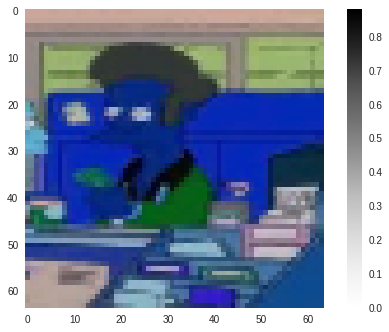

In [24]:
visualize_example(X_test[0])

**6.3 Precisión de cada variable **

A continuación vemos una tabla con la precisión de cada una de las 18 clases. Aquí podemos observar mayor precisión en las clases: 0, 5, 11, 14. 

In [25]:
# Se observa la precisión de cada variable

Y_test = np.argmax(Y_test, axis=1) 
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.96      0.98        48
          1       0.94      1.00      0.97        50
          2       0.90      0.92      0.91        50
          3       0.91      1.00      0.95        48
          4       0.91      0.98      0.94        50
          5       1.00      0.90      0.95        49
          6       0.98      0.96      0.97        50
          7       0.92      0.98      0.95        50
          8       0.98      0.98      0.98        50
          9       0.98      0.98      0.98        50
         10       0.98      0.82      0.89        50
         11       1.00      0.98      0.99        50
         12       0.98      1.00      0.99        49
         13       0.96      0.96      0.96        50
         14       1.00      0.98      0.99        49
         15       0.98      0.90      0.94        50
         16       0.91      0.98      0.94        50
         17       0.98      1.00      0.99   

## Paso 7  Aumento de datos y ajuste

Podemos incrementar el número de elementos de nuestro conjunto. La idea es alterar los datos de entrenamiento con pequeñas transformaciones para reproducir la variación que se produce durante una película.

Los enfoques que alteran los datos de entrenamiento en formas que cambian la representación de la matriz mientras mantienen la etiqueta igual se conocen como técnicas de aumento de datos. Algunos aumentos populares que usan las personas son escalas de grises, volteos horizontales, giros verticales, cultivos aleatorios, temblores de color, traslaciones, rotaciones y mucho más.

Al aplicar solo un par de estas transformaciones a nuestros datos de entrenamiento, puede duplicar o triplicar fácilmente el número de ejemplos de entrenamiento y crear un modelo muy robusto.

En el modelo con data augmentation el modelo necesita más épocas para entrenar. Esto se debe a que el conjunto de datos aumenta.

La diferencia es importante:

Sin aumento de datos obtuvimos una precisión del 87%.
Con el aumento de datos logramos 95% de precisión.

In [33]:
model2 = Sequential()


model2.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model2.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))


model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))


model2.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))


model2.add(Flatten())
model2.add(Dense(512, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(18, activation = "softmax"))
   
# Se observa una descripción de la arquitectura de la red neuronal

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        36928     
__________

In [0]:
# Se define el optimizer
adagrad = optimizers.adagrad()
#RMSprop = RMSprop(lr=0.001, decay=1e-6)
model2.compile(optimizer = adagrad , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
#X_train = X_train[np.random.permutation(len(X_train))]

validation_features = X_train[0:3798]
validation_labels = Y_train[0:3798]

In [36]:
# Generamos nuevos datos a partir de los que ya tenemos

datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    )


# Entrenamos el modelo con data augmentation

history2 = model2.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                   steps_per_epoch=len(X_train) / batch_size, epochs=15, validation_data=(validation_features, validation_labels))

Epoch 1/15
297/296 [==============================] - 33s 110ms/step - loss: 2.8215 - acc: 0.3011 - val_loss: 2.0931 - val_acc: 0.4018
Epoch 2/15
297/296 [==============================] - 30s 102ms/step - loss: 1.5508 - acc: 0.5308 - val_loss: 1.0856 - val_acc: 0.6796
Epoch 3/15
297/296 [==============================] - 31s 103ms/step - loss: 1.2065 - acc: 0.6356 - val_loss: 0.8394 - val_acc: 0.7541
Epoch 4/15
297/296 [==============================] - 30s 102ms/step - loss: 0.9722 - acc: 0.7035 - val_loss: 1.3212 - val_acc: 0.6804
Epoch 5/15
297/296 [==============================] - 30s 102ms/step - loss: 0.8131 - acc: 0.7497 - val_loss: 0.6689 - val_acc: 0.8009
Epoch 6/15
297/296 [==============================] - 31s 103ms/step - loss: 0.7138 - acc: 0.7799 - val_loss: 0.5163 - val_acc: 0.8610
Epoch 7/15
297/296 [==============================] - 30s 102ms/step - loss: 0.6261 - acc: 0.8065 - val_loss: 0.4015 - val_acc: 0.8865
Epoch 8/15
297/296 [==============================] - 3

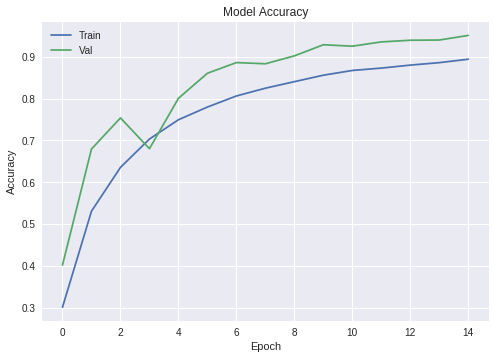

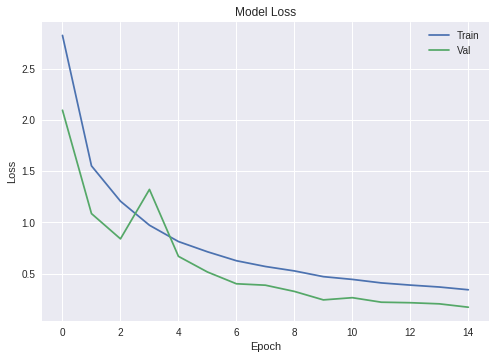

In [37]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history2)

plot_loss(history2)

### Comparación de los modelos

Si observamos la precisión de los modelos, vemos que data augmentation mejoró notablemente los resultados. Sin embargo como tenemos más datos se requiere más épocas para entrenar.

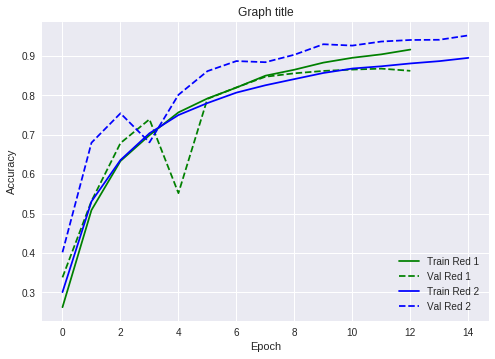

In [38]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_compare_accs(history, history2)